In [3727]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.sparse.linalg import eigsh
import copy

In [ ]:
# Určení hodnoty parametru beta
TASK = 'reaction' #'convection' nebo 'reaction'
if TASK == 'convection':
    BETA = 10
elif TASK == 'reaction':
    RHO = 2

# Metoda seq2seq training pro 1D úlohu konvekce a reakce

**1D úloha konvekce:**
\begin{align*}
     \frac{\partial u}{\partial t}+\beta\frac{\partial u}{\partial x}&=0,\:\:x\in\langle 0,2\pi\rangle,\:\:t\in\langle 0,1  \rangle,\\
    u(x,0)&=\sin(x)+\cos(x),\\
    u(0,t)&=u(2\pi,t),
\end{align*}
kde $\beta>0$ je koeficient konvekce.
Analytické řešení této úlohy je 
\begin{equation} u(x,t)=\sin(x-\beta t)+\cos(x-\beta t). \end{equation}

**1D reakční úloha:**
\begin{align*}
     \frac{\partial u}{\partial t}-\rho u(1-u)&=0,\:\:x\in\langle 0,2\pi\rangle,\:\:t\in\langle 0,1\rangle,\\
    u(x,0)&=\mathrm{exp}\left(-\frac{\left(x-\frac{\pi}{2}\right)^2}{2\left(\frac{\pi}{4}\right)^2}\right)+\mathrm{exp}\left(-\frac{\left(x-\frac{3\pi}{2}\right)^2}{2\left(\frac{\pi}{4}\right)^2}\right)=:h(x),\\ 
    u(0,t)&=u(2\pi,t),
\end{align*}
kde $\rho\in\mathbb{R}$ je reakční koeficient.
Analytické řešení této úlohy je 
\begin{equation} u(x,t)=\frac{h(x)\mathrm{e}^{\rho t}}{h(x)\mathrm{e}^{\rho t}+1-h(x)}. \end{equation}

Parametr 'TASK' určuje, kterou úlohu budeme řešit. Zvolíme 'convection' nebo 'reaction'.

Použijeme NN s 5 skrytými vrstvami s aktivační funkcí $tanh()$ s 20 neurony v každé vrstvě.
Trénování provedeme postupně na jednotlivých časových úsecích s délkou kroku $\Delta t$. V každém úseku vygenerujeme $1000\cdot \Delta t$ rovnoměrně rozložených bodů uvnitř oblasti a 150 bodů na hranici.
Pro první úsek provedeme 3000 epoch a pro každý další úsek provedeme vždy o 100 epoch méně.
Nejdříve využijeme optimalizátor Adam s learning rate $5\cdot 10^{-3}$ a poté optimalizátor LBFGS s learning rate $10^{-1}$, maximálním počtem iterací v optimalizačním kroku $20$ a update history size $10$ na poslední $1/3$ počtu epoch. Po každém úseku trénování uložíme nastavení modelu pro pozdější aproximaci.
Testování provedeme na 15000 náhodně rozložených bodech vygenerovaných metodou LHS.

Proces definice, učení a testování neuronové sítě je rozdělen do několika kroků:

**Krok 1:**
Definujeme architekturu neuronové sítě.
Vytvoříme pomocné funkce:
- `generate_inner_train_data()` pro generování trénovacích bodů uvnitř daného úseku,
- `generate_boundaries()` pro generování trénovacích bodů na hranici daného úseku,
- `plot_boundaries()` pro vykreslení trénovacích bodů,
- `compute_derivatives_2d()` pro výpočet derivací,
- `h_reaction()` pro výpočet počáteční podmínky úlohy reakce,
- `exact_solution_convection()` a `exact_solution_reaction()` pro výpočet analytického řešení,
- `generate_test_data_lhs()` pro vygenerování testovacích dat metodou LHS.

**Krok 2:**
Definujeme funkce pro výpočet ztráty a funkce closure pro použití optimalizátoru LBFGS:
- `compute_loss_convection()` a `compute_loss_reaction()` pro výpočet ztrátové funkce,
- `closure_convection()` a `closure_reaction()` pro použití optimalizátoru LBFGS.

**Krok 3:**
Vygenerujeme trénovací data pro první časový úsek, inicializujeme model a optimalizátor Adam.

**Krok 4:**
Spustíme trénovací smyčku.
Vykreslíme graf znázorňující závislost ztráty na počtu epoch.

**Krok 5:**
Vykreslíme aproximace řešení pomocí NN s využitím interpolace.
Vykreslíme řezy přesného a aproximovaného řešení v t=0,25; t=0,5; t=0,75.

**Krok 6:**
Výpočteme střední bodovou relativní a absolutní chybu aproximace řešení pomocí NN a vykreslíme bodovou relativní chybu aproximace řešení pomocí NN.

In [3729]:
# Krok 1.1: Definice modelu neuronové sítě 
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(2, 20)  # Vstup je 2D, proto 2 vstupy (x,t)
        self.tanh1 = nn.Tanh()
        self.fc2 = nn.Linear(20, 20)
        self.tanh2 = nn.Tanh()
        self.fc3 = nn.Linear(20, 20)
        self.tanh3 = nn.Tanh()
        self.fc4 = nn.Linear(20, 20)
        self.tanh4 = nn.Tanh()
        self.fc5 = nn.Linear(20, 20)
        self.tanh5 = nn.Tanh()
        self.fc6 = nn.Linear(20, 1)  # Výstup je skalár u(x,t)

    def forward(self, x):
        x = self.fc1(x)
        x = self.tanh1(x)
        x = self.fc2(x)
        x = self.tanh2(x)
        x = self.fc3(x)
        x = self.tanh3(x)
        x = self.fc4(x)
        x = self.tanh4(x)
        x = self.fc5(x)
        x = self.tanh5(x)
        x = self.fc6(x)
        return x

In [ ]:
# Krok 1.2: Funkce pro generování rovnoměrně rozložených trénovacích dat
def generate_inner_train_data(no_points, t_step, current_step): # Body uvnitř oblasti
    t = torch.linspace((current_step*t_step)+1e-3, (current_step+1)*t_step-1e-3, int(torch.sqrt(torch.tensor(no_points)))) 
    x = torch.linspace(0+1e-3, 2*np.pi-1e-3 , int(torch.sqrt(torch.tensor(no_points)))) 
    T, X = torch.meshgrid(t, x)

    t = T.reshape(-1, 1)
    x = X.reshape(-1, 1)

    t_train = t.view(-1,1)
    x_train = x.view(-1,1)

    return (t_train, x_train)

def generate_boundaries(no_points, t_step, current_step): # Body na hranici
    t_bottom = torch.linspace(current_step*t_step,(current_step+1)*t_step, no_points).view(-1, 1)
    x_bottom = torch.zeros_like(t_bottom)
    x_left = torch.linspace(0, 2*np.pi, no_points).view(-1, 1)
    t_left = current_step*t_step*torch.ones_like(x_left)
    t_top = torch.linspace(current_step*t_step,(current_step+1)*t_step, no_points).view(-1, 1)
    x_top = 2*np.pi*torch.ones_like(t_top)

    return (t_bottom, x_bottom, t_top, x_top, t_left, x_left)

In [ ]:
# Krok 1.3: Funkce pro vykreslení trénovacích bodů
def plot_boundaries(t_train, x_train, t_bottom, x_bottom, t_top, x_top, t_left, x_left):
    plt.figure(figsize=(12, 12))
    plt.scatter(t_bottom.numpy(), x_bottom.numpy(), label="Dolní",s=5, color='blue')
    plt.scatter(t_top.numpy(), x_top.numpy(), label="Horní",s=5, color='green')
    plt.scatter(t_left.numpy(), x_left.numpy(), label="Levé",s=5, color='red')
    plt.scatter(t_train.numpy(), x_train.numpy(), label="Vnitřní",s=10, color='yellow')
    plt.axhline(0, color='black',linewidth=1)
    plt.axvline(0, color='black',linewidth=1)
    plt.title("Trénovací data")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.grid(True)
    plt.show()
    return

In [ ]:
# Krok 1.4: Funkce pro výpočet derivací
def compute_derivatives_2d(model, x, y): # Výpočet derivací pomocí funkce autograd z knihovny PyTorch
    inputs = torch.hstack((x,y)).requires_grad_(True)
    u = model(inputs)
    
    # První derivace
    u_x = grad(u, inputs, torch.ones_like(u), create_graph=True)[0][:, 0:1]  # du/dx
    u_y = grad(u, inputs, torch.ones_like(u), create_graph=True)[0][:, 1:2]  # du/dy
    
    # Druhé derivace
    u_xx = grad(u_x, inputs, torch.ones_like(u_x), create_graph=True)[0][:, 0:1]  # d²u/dx²
    u_yy = grad(u_y, inputs, torch.ones_like(u_y), create_graph=True)[0][:, 1:2]  # d²u/dy²
    
    return (u, u_x, u_y, u_xx, u_yy)

In [ ]:
# Krok 1.5: Funkce pro výpočet analytického řešení
def exact_solution_convection(t_data, x_data):
    u = torch.sin(x_data - BETA*t_data) + torch.cos(x_data - BETA*t_data)
    return u
def h_reaction(x):
    return torch.exp(-(x-torch.pi/2)**2/(2*(torch.pi/4)**2))+torch.exp(-(x-3*torch.pi/2)**2/(2*(torch.pi/4)**2))
def exact_solution_reaction(t_data, x_data):
    u = (h_reaction(x_data)*torch.exp(RHO*t_data))/(h_reaction(x_data)*torch.exp(RHO*t_data)+1-h_reaction(x_data))
    return u

In [ ]:
# Krok 1.6: Funkce pro vygenerování testovacích dat v oblasti (i na její hranici) a funkce pro jejich uspořádání
def generate_test_data_lhs(no_points):
    # Body uvnitř a na hranici oblasti
    no_inside_points = int(no_points * 0.97)
    no_boundary_points = no_points - no_inside_points

    # Funkce pro generování pomocí LHS
    def latin_hypercube_sampling(num_samples, dim):
        # Mřížka intervalů
        grid = torch.linspace(0, 1, num_samples + 1)[:-1].unsqueeze(1)
        grid = grid + (torch.rand(num_samples, dim) / num_samples)
        for d in range(dim):
            grid[:, d] = grid[torch.randperm(num_samples), d]
        return grid

    # Vnitřní body
    lhs_inside = latin_hypercube_sampling(no_inside_points, 2)
    x_inside = lhs_inside[:, 0:1]
    y_inside = lhs_inside[:, 1:2] * 2 * np.pi  # Transformace na interval (0, 2*pi)

    # Body na hranici
    lhs_boundary = latin_hypercube_sampling(no_boundary_points, 1)
    side_assignments = torch.randint(0, 4, (no_boundary_points,)) 
    x_boundary = torch.zeros(no_boundary_points, 1)
    y_boundary = torch.zeros(no_boundary_points, 1)

    # Přiřazení bodů na hranice: 0 -> horní, 1 -> dolní, 2 -> levá, 3 -> pravá
    x_boundary[side_assignments == 0] = lhs_boundary[side_assignments == 0]
    y_boundary[side_assignments == 0] = 2 * np.pi  # Horní hranice

    x_boundary[side_assignments == 1] = lhs_boundary[side_assignments == 1]
    y_boundary[side_assignments == 1] = 0  # Dolní hranice

    x_boundary[side_assignments == 2] = 0  # Levá hranice
    y_boundary[side_assignments == 2] = lhs_boundary[side_assignments == 2] * 2 * np.pi

    x_boundary[side_assignments == 3] = 1  # Pravá hranice
    y_boundary[side_assignments == 3] = lhs_boundary[side_assignments == 3] * 2 * np.pi

    # Spojení bodů
    x_test = torch.cat((x_inside, x_boundary), dim=0)
    y_test = torch.cat((y_inside, y_boundary), dim=0)

    return (x_test, y_test)

def sort_data(t_test, x_test):

    sorted_indices = torch.argsort(t_test.squeeze(), stable=True)

    t_test_sorted = t_test[sorted_indices]
    x_test_sorted = x_test[sorted_indices]

    return (t_test_sorted, x_test_sorted)

In [ ]:
# Krok 2.1: Definice ztrátové funkce
def compute_loss_convection(model, t_train, x_train, t_bottom, x_bottom, t_top, x_top, t_left, x_left, start_condition, section):
    # PDR ztráta
    _, u_t_train, u_x_train, _, _ = compute_derivatives_2d(model, t_train, x_train) # Výpočet derivací
    pde_loss = torch.mean((u_t_train + BETA * u_x_train)**2)
    
    # Ztráta na hranici
    if section == 0:
        u_left = model(torch.cat([t_left, x_left], dim=1))
        left_loss = torch.mean((u_left - (torch.sin(x_left)+torch.cos(x_left)))**2)
    else:
        u_left = model(torch.cat([t_left, x_left], dim=1))
        left_loss = torch.mean((u_left - start_condition)**2)

    u_top = model(torch.cat([t_top, x_top], dim=1))
    u_bottom = model(torch.cat([t_bottom, x_bottom], dim=1))
    top_bottom_loss = torch.mean((u_bottom - u_top)**2)

    # Celková ztráta
    total_loss = pde_loss + left_loss + top_bottom_loss
    return total_loss

def compute_loss_reaction(model, t_train, x_train, t_bottom, x_bottom, t_top, x_top, t_left, x_left, start_condition, section):
    # PDR ztráta
    u_train, u_t_train, _, _, _ = compute_derivatives_2d(model, t_train, x_train) # Výpočet derivací
    pde_loss = torch.mean((u_t_train - RHO*u_train*(torch.ones_like(u_train)-u_train))**2)
    
    # Ztráta na hranici
    if section == 0:
        u_left = model(torch.cat([t_left, x_left], dim=1))
        left_loss = torch.mean((u_left - h_reaction(x_left))**2)
    else:
        u_left = model(torch.cat([t_left, x_left], dim=1))
        left_loss = torch.mean((u_left - start_condition)**2)

    u_top = model(torch.cat([t_top, x_top], dim=1))
    u_bottom = model(torch.cat([t_bottom, x_bottom], dim=1))
    top_bottom_loss = torch.mean((u_bottom - u_top)**2)

    # Celková ztráta
    total_loss = pde_loss + left_loss + top_bottom_loss
    return total_loss

In [ ]:
# Krok 2.2: Funkce closure pro použití optimalizátoru LBFGS
def closure_convection():
    optimizer.zero_grad()

    loss = compute_loss_convection(model, t_train, x_train, t_bottom, x_bottom, t_top, x_top, t_left, x_left, start_condition, section)

    loss.backward(retain_graph=True)
    return loss

def closure_reaction():
    optimizer.zero_grad()

    loss = compute_loss_reaction(model, t_train, x_train, t_bottom, x_bottom, t_top, x_top, t_left, x_left, start_condition, section)

    loss.backward(retain_graph=True)
    return loss

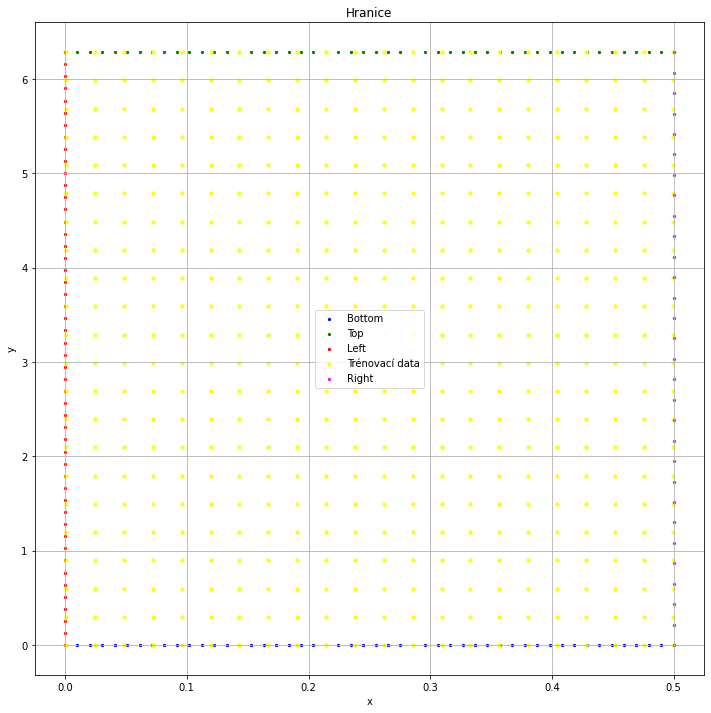

In [ ]:
# Krok 3.1: Vygenerování trénovacích dat pro první časový úsek
t_delta = 0.5
t_step = 0
num_sections = int(1/t_delta)
t_train, x_train = generate_inner_train_data(int(1000/(1/t_delta)), t_delta, t_step) # Body uvnitř oblasti
t_bottom, x_bottom, t_top, x_top, t_left, x_left = generate_boundaries(50, t_delta, t_step) # Body na hranici oblasti

plot_boundaries(t_train, x_train, t_bottom, x_bottom, t_top, x_top, t_left, x_left) # Vykreslení trénovacích dat

In [ ]:
# Krok 3.2: Inicializace modelu a optimalizátoru
model = MyModel()
optimizer = optim.Adam(model.parameters(), lr=5e-3) 

if TASK == 'convection':
    compute_loss = compute_loss_convection
    closure = closure_convection
    exact_solution = exact_solution_convection
elif TASK == 'reaction':
    compute_loss = compute_loss_reaction
    closure = closure_reaction
    exact_solution = exact_solution_reaction

In [ ]:
# Krok 4.1: Trénovací smyčka
loss_values = [] # Seznam pro ukládání ztráty v každé epoše
parameter_values = [] # Seznam pro ukládání nastavení NN po každém úseku trénování
start_condition = torch.zeros_like(x_left) # Paramter pro uložení počáteční podmínky
epochs_per_section = 3000
epochs = 0
best_loss = float('inf')
t_step = 0
t_train, x_train = generate_inner_train_data(int(1000/(1/t_delta)), t_delta, t_step) # Body uvnitř oblasti
t_bottom, x_bottom, t_top, x_top, t_left, x_left = generate_boundaries(50, t_delta, t_step) # Body na hranici oblasti
for section in range(num_sections):
    print(f"section:{section}")
    best_epoch = -1 
    best_model_state_dict = None
    best_loss = float('inf')
    for epoch in range(epochs_per_section):
        if epoch <= epochs_per_section-int(epochs_per_section/3):
            optimizer.zero_grad() 
        
            # Výpočet ztráty
            loss = compute_loss(model, t_train, x_train, t_bottom, x_bottom, t_top, x_top, t_left, x_left, start_condition, section)

            loss.backward() # Backward pass
            optimizer.step() # Optimalizace
        else:
            loss = optimizer.step(closure)

        if epoch == epochs_per_section-int(epochs_per_section/3):
            print(f"Změna optimalizátoru v epoše {epoch + 1}. Použití NN s nejlepší ztrátou {best_loss:.6f}")
            model.load_state_dict(best_model_state_dict)
            optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1, max_iter=20, history_size=10)

        loss_values.append(loss.detach().numpy())

        if loss.item() < best_loss:
            best_loss = loss.item()
            best_epoch = epoch
            best_model_state_dict = copy.deepcopy(model.state_dict())

        if (epoch + 1) % 200 == 0:
            print(f'Epocha {epoch+1}/{epochs_per_section} v sekci {section+1}, Ztráta: {loss.item()}')
    parameter_values.append(copy.deepcopy(model.state_dict())) # Uložení parametrů modelu pro daný úsek
    epochs = epochs + epochs_per_section
    # Vygenerování dat pro další časový úsek
    if section + 1 != num_sections:
        t_step = t_step + 1
        epochs_per_section = epochs_per_section-100
        print(f'Step change: {t_step}')
        t_train, x_train = generate_inner_train_data(int(1000/(1/t_delta)), t_delta, t_step) # Body uvnitř oblasti
        t_bottom, x_bottom, t_top, x_top, t_left, x_left = generate_boundaries(50, t_delta, t_step) # Body na hranici oblasti
        with torch.no_grad():
            inputs_left = torch.cat([t_left, x_left], dim=1)
            u_pred_left = model(inputs_left)
        start_condition = u_pred_left
        optimizer = optim.Adam(model.parameters(), lr=5e-3)

section:0
Epocha 200/3000, Ztráta: 0.4341588616371155
Epocha 400/3000, Ztráta: 0.43399980664253235
Epocha 600/3000, Ztráta: 0.4338493347167969
Epocha 800/3000, Ztráta: 0.43361830711364746
Epocha 1000/3000, Ztráta: 0.433626264333725
Epocha 1200/3000, Ztráta: 0.43300411105155945
Epocha 1400/3000, Ztráta: 0.43319880962371826
Epocha 1600/3000, Ztráta: 0.43266862630844116
Epocha 1800/3000, Ztráta: 0.43267402052879333
Epocha 2000/3000, Ztráta: 0.4324790835380554
Změna optimalizátoru v epoše 2001. Použití NN s nejlepší ztrátou 0.432479
Epocha 2200/3000, Ztráta: 0.43170860409736633
Epocha 2400/3000, Ztráta: 0.43170860409736633
Epocha 2600/3000, Ztráta: 0.43170860409736633
Epocha 2800/3000, Ztráta: 0.43170860409736633
Epocha 3000/3000, Ztráta: 0.43170860409736633
Step change: 1
section:1
Epocha 200/2900, Ztráta: 0.0001344737538602203
Epocha 400/2900, Ztráta: 0.00011627010098891333
Epocha 600/2900, Ztráta: 0.00010918275802396238
Epocha 800/2900, Ztráta: 0.0001041973737301305
Epocha 1000/2900, Zt

Nejlepší epocha 5899, Ztráta: 8.902167610358447e-05


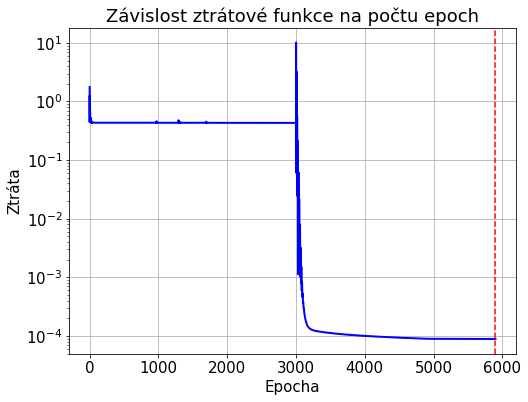

In [ ]:
# Krok 4.2: Graf znázorňující závislost ztráty na počtu epoch
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), loss_values, color='blue', linewidth=2)
plt.yscale('log')
plt.title('Závislost ztrátové funkce na počtu epoch', fontsize=18)
plt.xlabel('Epocha', fontsize=15)
plt.ylabel('Ztráta', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True)
plt.show()

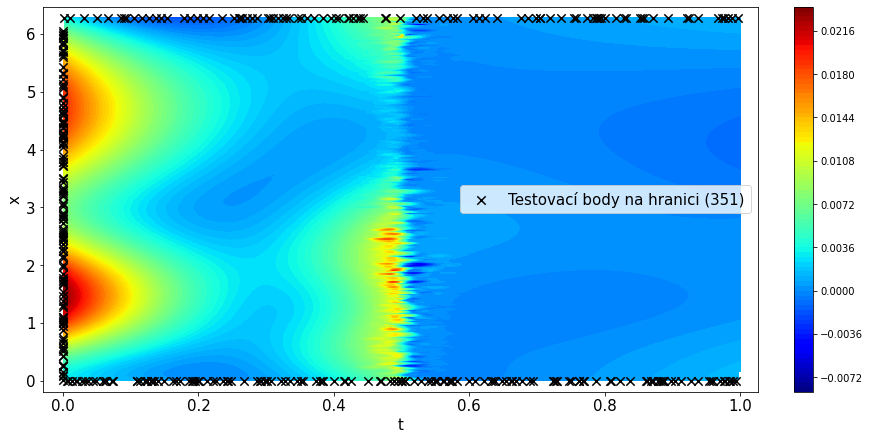

In [ ]:
# Krok 5.1: Vykreslení aproximace NN řešení zadané úlohy ve 2D grafu s interpolací
t_test, x_test = generate_test_data_lhs(15000) # Vygenerování testovacích dat
t_test, x_test = sort_data(t_test, x_test) # Uspořádání testovacích dat
all_u_preds = [] # Seznam pro ukládání predikcí
for i in range(num_sections):
    model.load_state_dict(parameter_values[i])
    if i != 0:
        mask = (t_test > i*t_delta) & (t_test <= (i+1)*t_delta)
    else:
        mask = (t_test >= i*t_delta) & (t_test <= (i+1)*t_delta)
    t_selected = t_test[mask].view(-1, 1)
    x_selected = x_test[mask].view(-1, 1)
    selected_inputs = torch.cat([t_selected, x_selected], dim=1)
    with torch.no_grad():
        u_pred_section = model(selected_inputs) 
    all_u_preds.append(u_pred_section)
u_pred = torch.cat(all_u_preds, dim=0)

# Interpolace
fig, axes = plt.subplots(1, 1, figsize=(12, 6), constrained_layout=True)

t = t_test.detach().cpu().numpy().squeeze()
x = x_test.detach().cpu().numpy().squeeze()
z = u_pred.detach().cpu().numpy().squeeze()

grid_t, grid_x = np.linspace(0, 1, 500), np.linspace(0, 2*np.pi, 500)
grid_t, grid_x = np.meshgrid(grid_t, grid_x)
grid_z = griddata((t, x), z, (grid_t, grid_x), method="cubic")

# Vykreslení
ax = axes
im = ax.contourf(grid_t, grid_x, grid_z, levels=100, cmap="jet", vmin=None, vmax=None)
cbar = fig.colorbar(im, ax=ax, orientation="vertical")
ax.set_xlabel("t", fontsize=15)
ax.set_ylabel("x", fontsize=15)
# Vykreslení bodů na hranici
boundary_mask = (x == 0) | (x == 2*np.pi) | (t == 0)
t_boundary = t[boundary_mask]
x_boundary = x[boundary_mask]
no_bound_points = len(t_boundary)
ax.scatter(t_boundary, x_boundary, color="black", s=70, label=f"Testovací body na hranici ({no_bound_points})", marker="x")

ax.legend(fontsize=15)
x_padding = 0.03 * (x_boundary.max() - x_boundary.min())  # Přidání okrajů
t_padding = 0.03 * (t_boundary.max() - t_boundary.min())
ax.set_xlim(t_boundary.min() - t_padding, t_boundary.max() + t_padding)
ax.set_ylim(x_boundary.min() - x_padding, x_boundary.max() + x_padding)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

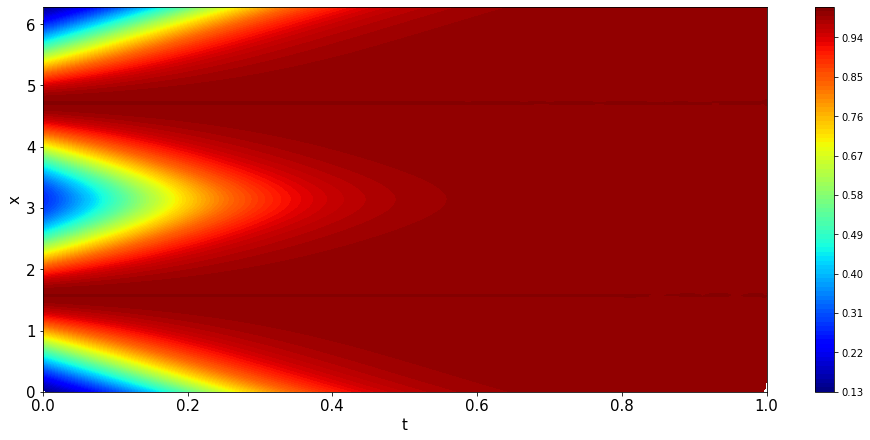

In [3743]:
# Krok 5.2: Vykreslení přesného řešení
true_values = exact_solution(t_test, x_test)

# Interpolace
fig, axes = plt.subplots(1, 1, figsize=(12, 6), constrained_layout=True)

t = t_test.detach().cpu().numpy().squeeze()
x = x_test.detach().cpu().numpy().squeeze()
z = true_values.detach().cpu().numpy().squeeze()

grid_t, grid_x = np.linspace(0, 1, 500), np.linspace(0, 2*np.pi, 500)
grid_t, grid_x = np.meshgrid(grid_t, grid_x)
grid_z = griddata((t, x), z, (grid_t, grid_x), method="cubic")

# Vykreslení
ax = axes
im = ax.contourf(grid_t, grid_x, grid_z, levels=100, cmap="jet", vmin=None, vmax=None)
cbar = fig.colorbar(im, ax=ax, orientation="vertical")
ax.set_xlabel("t", fontsize=15)
ax.set_ylabel("x", fontsize=15)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [3744]:
# Krok 5.3: Definice funkce pro vykreslení řezů aproximace řešení pomocí NN a přesného řešení
def plot_solution_cut_with_exact(t_fixed, t_test, x_test, u_pred):
    t = t_test.detach().cpu().numpy().squeeze()
    x = x_test.detach().cpu().numpy().squeeze()
    z = u_pred.detach().cpu().numpy().squeeze()

    # Body poblíž řezu
    tolerance = 1e-3
    mask = np.abs(t - t_fixed) < tolerance
    x_filtered = x[mask]
    z_filtered = z[mask]

    # Odstranění duplicitních dat
    x_filtered, unique_indices = np.unique(x_filtered, return_index=True)
    z_filtered = z_filtered[unique_indices]

    # Interpolace
    x_interp = np.linspace(x_filtered.min(), x_filtered.max(), 500)
    z_interp = griddata(x_filtered, z_filtered, x_interp, method="cubic")

    # Přesné řešení
    t_fixed_tensor = torch.full((500, 1), t_fixed)
    x_interp_tensor = torch.tensor(x_interp, dtype=torch.float32).view(-1, 1)
    exact_z = exact_solution(t_fixed_tensor, x_interp_tensor)
    exact_z = exact_z.detach().cpu().numpy().squeeze()

    # Vykreslení predikcí a přesného řešení
    plt.figure(figsize=(12, 12))
    plt.plot(x_interp, exact_z, label="Analytické řešení", color="blue", linewidth=5)
    plt.plot(x_interp, z_interp, label=f"Predikce NN (t = {t_fixed:.3f})", color="red",linestyle="--", linewidth=5)
    plt.title(f"Řez v t = {t_fixed:.3f}", fontsize=18)
    plt.xlabel("x", fontsize=15)
    plt.ylabel("u", fontsize=15)
    plt.legend(fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15) 
    plt.grid()
    plt.show()

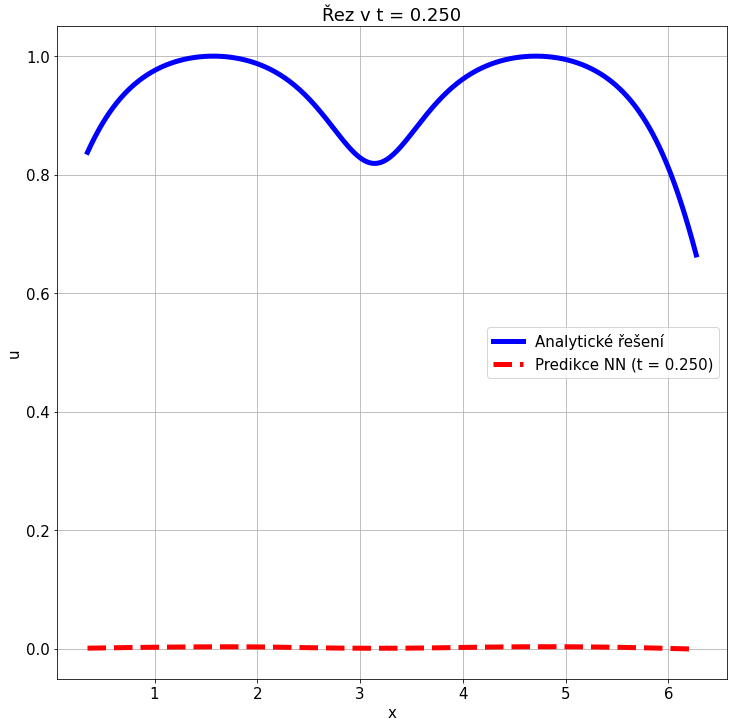

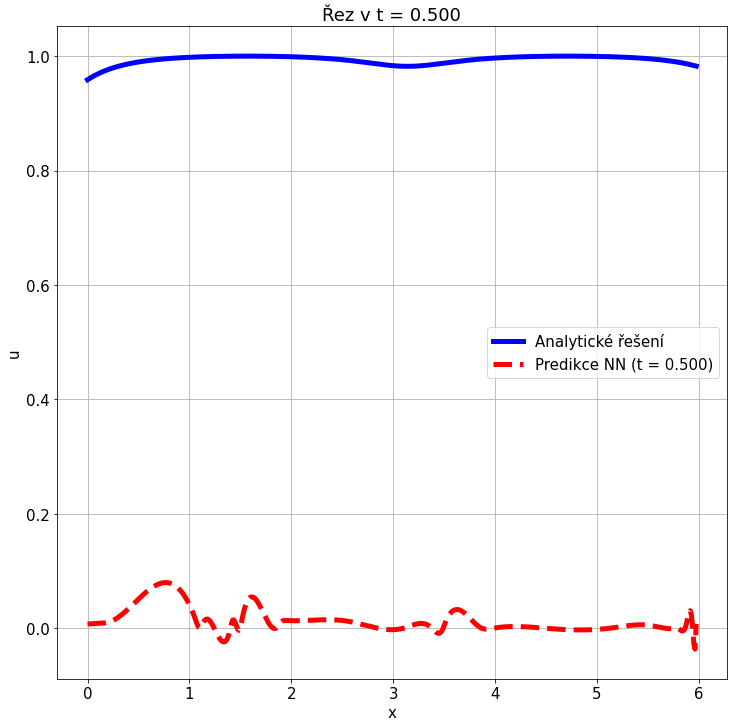

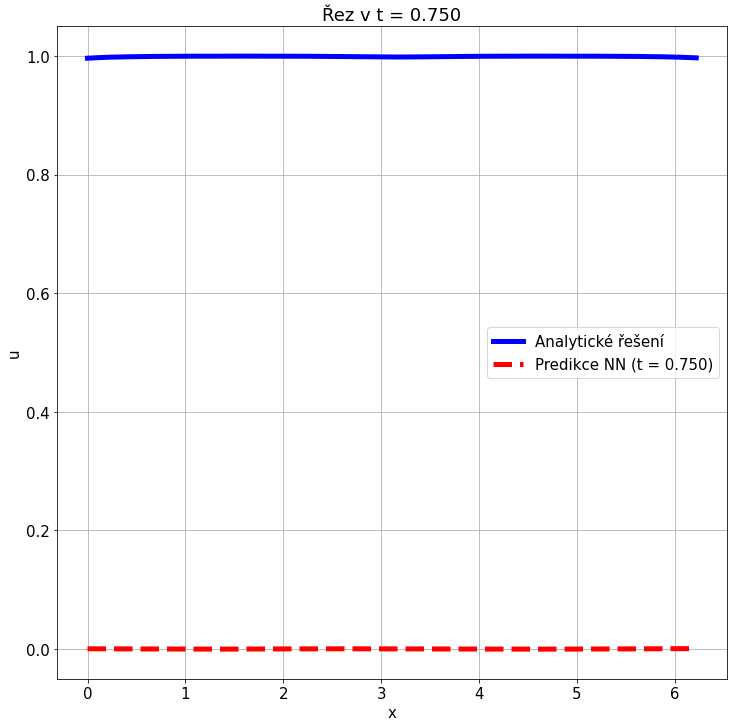

In [3745]:
# Krok 5.4: Vykreslení řezů přesného a aproximovaného řešení v t=0,25; t=0,5; t=0,75
plot_solution_cut_with_exact(0.25, t_test, x_test, u_pred)
plot_solution_cut_with_exact(0.5, t_test, x_test, u_pred)
plot_solution_cut_with_exact(0.75, t_test, x_test, u_pred)

In [3746]:
# Krok 6.1: Výpočet střední bodové relativní a absolutní chyby aproximace řešení NN
true_values = exact_solution(t_test, x_test)

pws_absolute_errors = torch.norm(u_pred - true_values, dim=1)
mean_absolute_error = torch.mean(pws_absolute_errors)

F = torch.max(torch.abs(true_values))
absolute_errors = torch.abs(u_pred - true_values)
relative_errors_F = absolute_errors / F
mean_relative_error_F = torch.mean(relative_errors_F)

print(f'Střední bodová absolutní chyba: {mean_absolute_error.item():.6f}')
print(f'Střední bodová relativní chyba: {mean_relative_error_F.item():.6f}')

Střední bodová absolutní chyba: 0.931049
Střední bodová relativní chyba: 0.930761


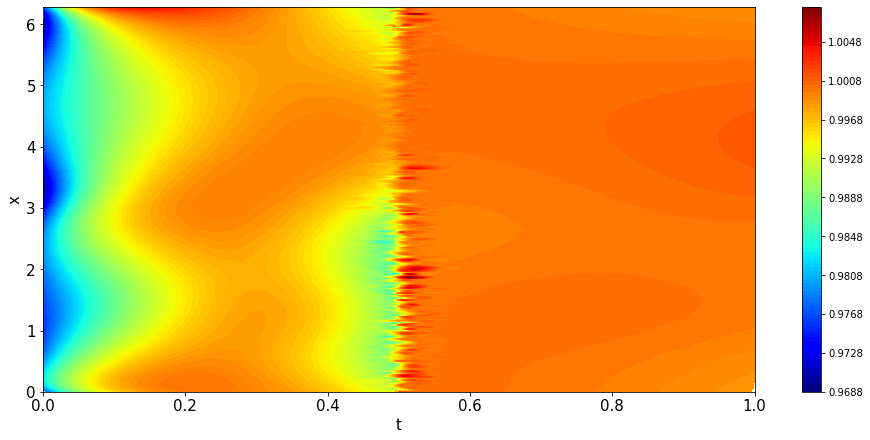

In [ ]:
# Krok 6.2: Výpočet a vykreselní relativní pointwise chyby aproximace řešení NN
pointwise_relative_error = torch.abs((u_pred - true_values) / (true_values))

# Interpolace
fig, axes = plt.subplots(1, 1, figsize=(12, 6), constrained_layout=True) 

t = t_test.detach().cpu().numpy().squeeze()
x = x_test.detach().cpu().numpy().squeeze()
z = pointwise_relative_error.detach().cpu().numpy().squeeze()

grid_t, grid_x = np.linspace(0, 1, 500), np.linspace(0, 2*np.pi, 500)
grid_t, grid_x = np.meshgrid(grid_t, grid_x)
grid_z = griddata((t, x), z, (grid_t, grid_x), method="cubic")

# Vykreslení
ax = axes
im = ax.contourf(grid_t, grid_x, grid_z, levels=100, cmap="jet", vmin=None, vmax=None)
cbar = fig.colorbar(im, ax=ax, orientation="vertical")
ax.set_xlabel("t", fontsize=15)
ax.set_ylabel("x", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()